# Module Name: SE4050 - Deep Learning Assignment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Group memebr details:**

IT21251900 - Rajapaksha R.M.S.D

IT21302862 - Sri Samadhi L.A.S.S

IT21178054 - Kumari T.A.T.N

IT21360428 - Monali G.M.N.



**Key Objective**

The key objective of this project is to develop a machine learning model using Convolutional Neural Networks (CNN) to accurately identify diseases in potato leaves, specifically Early Blight and Late Blight, and determine if the plant is healthy.

**Methodology**

Supervised Learning

---



This project leverages supervised learning where the model is trained on labeled data—images of potato leaves categorized as Early Blight, Late Blight, or Healthy. This allows the model to learn features associated with each category and make predictions on new, unseen images.

Convolutional Neural Network (CNN)

---



CNNs are well-suited for image classification tasks due to their ability to automatically detect and learn hierarchical patterns like edges, textures, and shapes in images. The model architecture consists of multiple convolutional layers, pooling layers, and fully connected layers, which help in extracting features from the potato leaf images and classifying them into one of the three categories.

Dataset

The dataset used in this project is a Potato Leaf Disease Dataset, which consists of labeled images of potato leaves from three categories,

Early Blight: Leaves affected by the Early Blight disease caused by the fungus Alternaria solani.

Late Blight: Leaves affected by the Late Blight disease caused by the pathogen Phytophthora infestans.

Healthy: Leaves that are not affected by any disease and are classified as healthy.

Link: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

Import all the Dependencies

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset object

In [6]:

import os
import tensorflow as tf

# Step 1: Unzip the file from Google Drive to a local directory
zip_path = '/content/drive/MyDrive/DL_Project/PlantVillage'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    zip_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


Visualize some of the images from our dataset

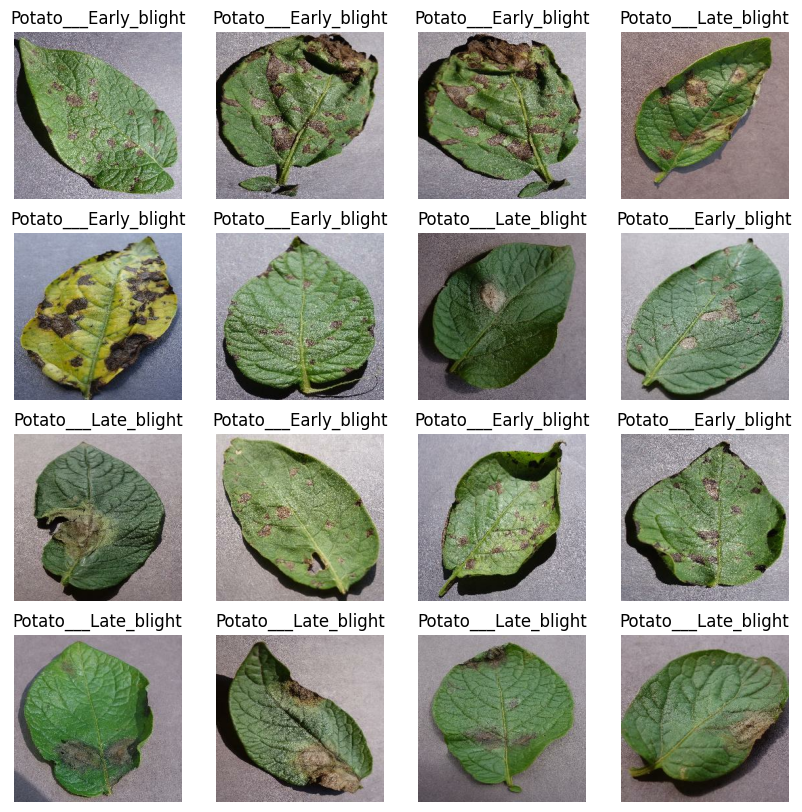

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely: **bold text**

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [11]:
len(dataset)

68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**IT21302862** - Building the Model

**Creating a Layer for Resizing and Normalization**

Before feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

**Data Augmentation**

This boosts the accuracy of our model by augmenting the data.

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**IT21302862** - Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**IT21302862** - Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.4312 - loss: 0.9595 - val_accuracy: 0.6354 - val_loss: 0.8600
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.6871 - loss: 0.7637 - val_accuracy: 0.7656 - val_loss: 0.5883
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - accuracy: 0.8042 - loss: 0.4430 - val_accuracy: 0.8854 - val_loss: 0.3083
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.9038 - loss: 0.2448 - val_accuracy: 0.9062 - val_loss: 0.2241
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.9382 - loss: 0.1706 - val_accuracy: 0.9010 - val_loss: 0.2900
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - accuracy: 0.9483 - loss: 0.1519 - val_accuracy: 0.9323 - val_loss: 0.1513
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9482 - loss: 0.1259 - val_accuracy: 0.9323 - val_loss: 0.1549
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - accuracy: 0.9452 - loss: 0.1401 - val_accuracy: 0.8385 - v

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9745 - loss: 0.0788


In [ ]:
scores

[0.09146903455257416, 0.96484375]

Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

20

In [ ]:
history.history['loss'][:5]

[0.9123921394348145,
 0.661983847618103,
 0.395614892244339,
 0.24741561710834503,
 0.1841520071029663]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

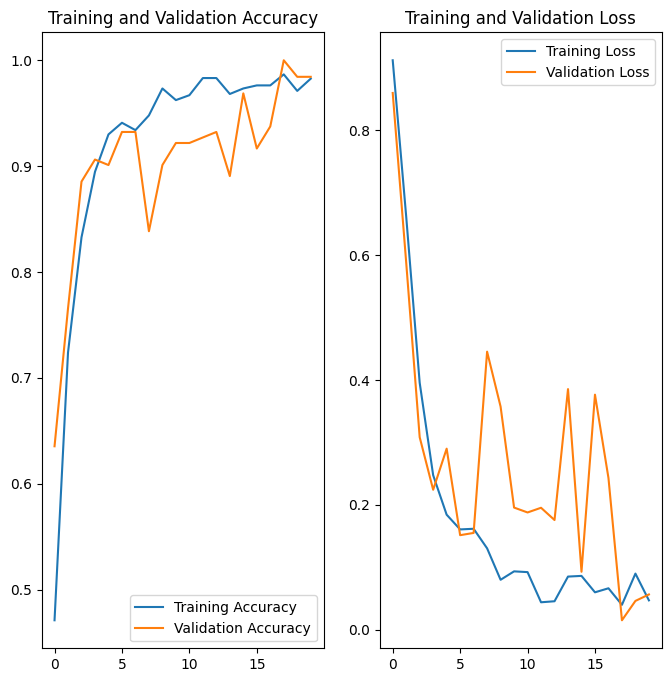

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

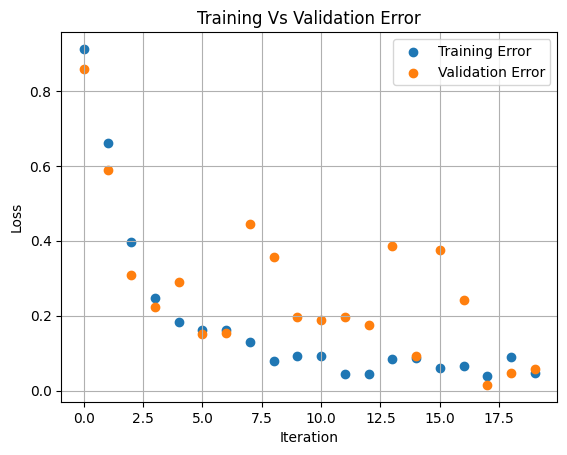

In [ ]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


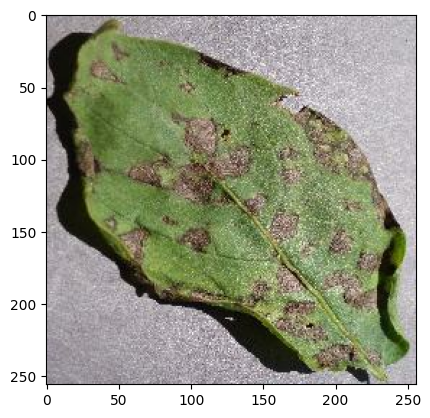

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


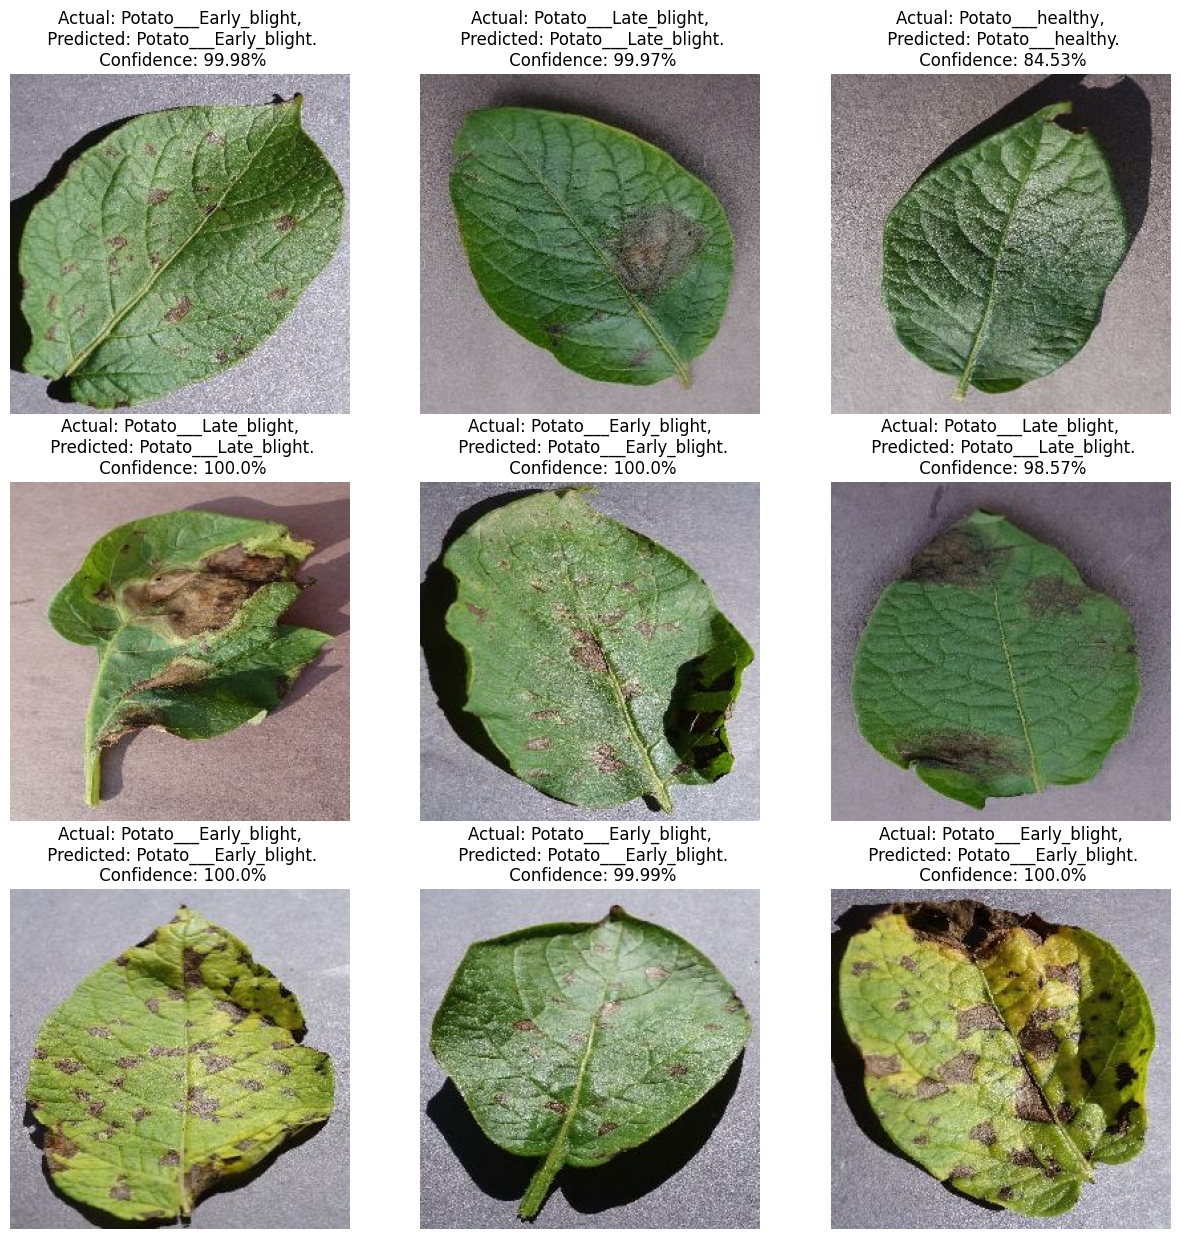

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Saving the Model**

We append the model to the list of models as a new version

In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists("../models"):
    os.makedirs("../models")

# Extract file names without extensions and convert them to integers
model_files = [f for f in os.listdir("../models") if f.endswith(".keras")]
model_versions = [int(f.split('.')[0]) for f in model_files]

# Get the maximum model version, or default to 0 if no models exist
model_version = max(model_versions + [0]) + 1

# Save the new model with the next version number
model.save(f"../models/{model_version}.keras")

In [ ]:
model.save("../potatoes.keras")

In [ ]:
import os

model_path = os.path.abspath(f"../models/{model_version}.keras")
print(f"Model saved at: {model_path}")


Model saved at: /models/1.keras


In [ ]:
import os
print(os.getcwd())

print(os.path.exists("../models"))
!ls /models



/content
True
1.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


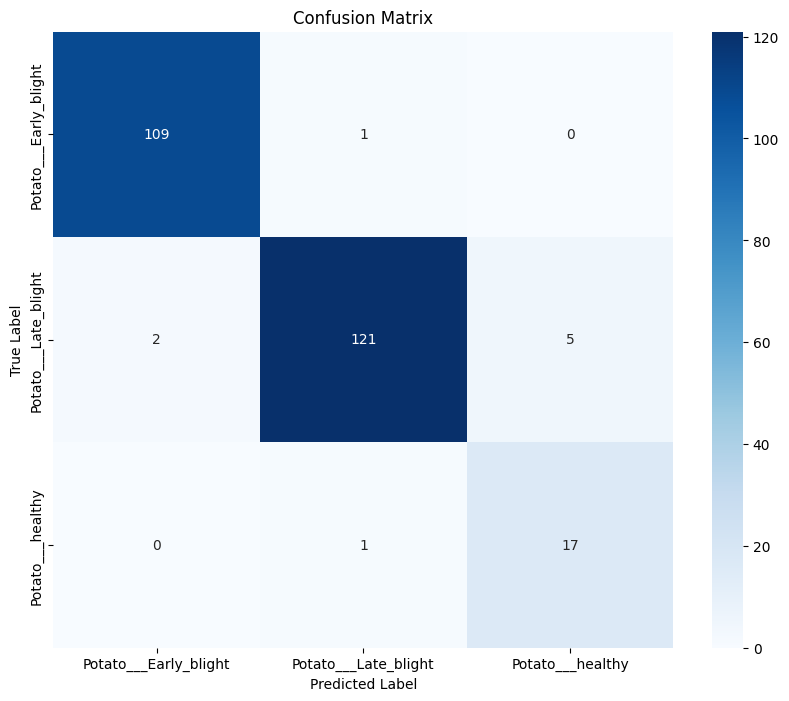

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


---**MODEL 02**---------------------------------------------------------------------------------------------------------------------------------------

### **IT21251900 - Resizing and Normalization**
In this section, we are preparing our dataset before feeding it into the neural network. We need to ensure that all images have a consistent size and their pixel values are normalized for better model performance.

Resizing and Rescaling Layer:

We use the Sequential API to create a preprocessing pipeline that resizes images to 224x224 pixels (the input size expected by VGG16) and normalizes the pixel values to a range between 0 and 1 by dividing them by 255.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # Import Sequential from tensorflow.keras.models
from tensorflow.keras import layers

resize_and_rescale = Sequential([
    layers.Resizing(224, 224),  # Resize to 224x224 (VGG16 input size)
    layers.Rescaling(1./255),   # Normalize pixel values between 0 and 1
])

Mapping Dataset

We apply the resize_and_rescale layer to the training, validation, and test datasets using the map function. This ensures that every image in each dataset is resized and normalized before feeding it into the model.

In [ ]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

Dataset Caching and Prefetching

To optimize the performance and reduce latency during training, we use caching, shuffling, and prefetching. These techniques allow us to preprocess the data while the model is training.
AUTOTUNE is used to adjust the prefetching buffer size automatically to improve efficiency.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **IT21251900 - Data Augmentation**
In this section, we implement data augmentation, which is a technique used to artificially increase the diversity of the training dataset by applying random transformations. This helps prevent overfitting and improves the generalization capability of the model.

Data Augmentation Layer

We define a Sequential model for data augmentation using TensorFlow's Keras layers.
The augmentation consists of

RandomFlip: Randomly flipping the image both horizontally and vertically, which introduces variations in the image orientation.

RandomRotation: Applying random rotations (up to 20% of the image) to further augment the dataset.

Applying Augmentation to the Training Dataset:

The data augmentation layer is applied only during training (not during validation or testing) using the training=True flag.
The map function is used to apply augmentation to each image in the training dataset, maintaining their corresponding labels.

In [25]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### **IT21251900 - Model Architecture**
This section defines a custom Convolutional Neural Network (CNN) model using the Sequential API. The architecture is built for image classification tasks and includes multiple convolutional layers for feature extraction, followed by dense layers for classification.

Convolutional and MaxPooling Layers:

**First Conv2D Layer**

A 2D convolution layer with 32 filters, each of size 3x3. The ReLU activation function is used to introduce non-linearity.
The input shape is set to (224, 224, 3), corresponding to RGB images of size 224x224.
A MaxPooling layer with a 2x2 pool size is added to downsample the image.

**Second Conv2D Layer**

Another Conv2D layer with 64 filters and 3x3 kernels, followed by MaxPooling for further downsampling.

**Third Conv2D Layer**

A Conv2D layer with 128 filters, followed by MaxPooling to capture more complex features.

**Fourth Conv2D Layer**

A Conv2D layer with 256 filters, with a MaxPooling layer to continue reducing the spatial dimensions.

**Fifth Conv2D Layer**

A final Conv2D layer with 512 filters and MaxPooling. This deeper layer captures even more complex features of the input images.
python



In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) # Changed input_shape to (224, 224, 3)
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Adjusted the architecture to reduce output volume before flattening
model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(512, (3, 3), activation='relu')) # Added another Conv2D layer
model_2.add(MaxPooling2D(pool_size=(2, 2))) # Added another MaxPooling2D layer


model_2.add(Flatten())
# This dense layer's input shape is adjusted automatically based on the preceding layer
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
num_classes = 10  # Replace 10 with the actual number of classes in your dataset
model_2.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model_2.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,848,202 (18.49 MB)

 Trainable params: 4,848,202 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 226s 477ms/step - accuracy: 0.4350 - loss: 1.3128 - val_accuracy: 0.4896 - val_loss: 0.9110
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 405ms/step - accuracy: 0.5306 - loss: 0.8869 - val_accuracy: 0.7188 - val_loss: 0.5950
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.7690 - loss: 0.5898 - val_accuracy: 0.8490 - val_loss: 0.3678
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.8321 - loss: 0.4559 - val_accuracy: 0.8438 - val_loss: 0.3740
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9019 - loss: 0.2735 - val_accuracy: 0.9375 - val_loss: 0.1580
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9160 - loss: 0.2483 - val_accuracy: 0.8177 - val_loss: 0.4385
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.8749 - loss: 0.3248 - val_accuracy: 0.9219 - val_loss: 0.2042
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 448ms/step - accuracy: 0.9455 - loss: 0.1667 - val_acc

In [30]:
scores = model_2.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9633 - loss: 0.1139


In [31]:

scores

[0.09651530534029007, 0.96875]

In [32]:

history

In [33]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
type(history.history['loss'])

list

In [35]:

len(history.history['loss'])

50

In [36]:
history.history['loss'][:5]

[1.0986090898513794,
 0.8417080044746399,
 0.5403401255607605,
 0.4388330578804016,
 0.2786407768726349]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

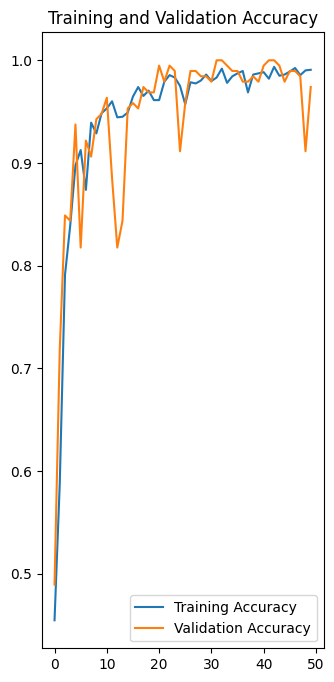

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

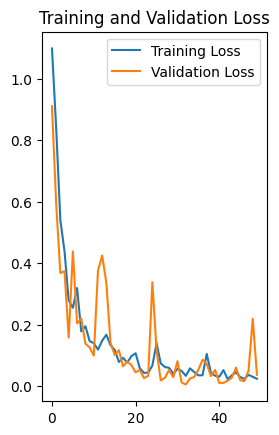

In [39]:
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

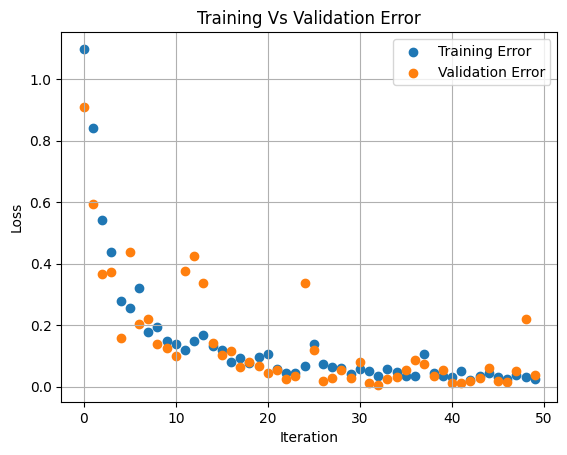

In [40]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [41]:
import tensorflow as tf
from tensorflow.keras import metrics

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


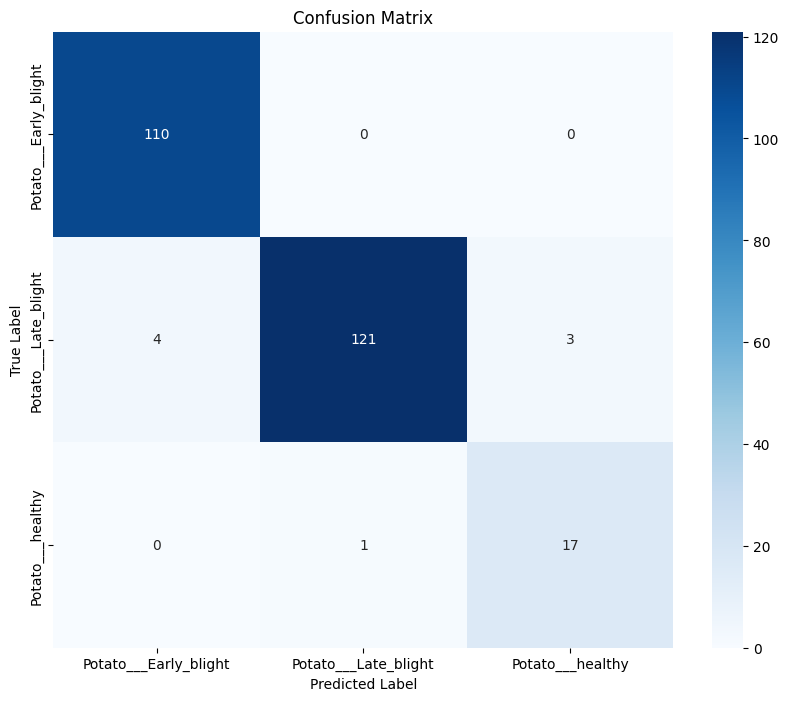

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model_2.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()